### MAT 653
#### Wei Li

## Hamiltonian Monte Carlo


In [1]:
import numpy as np


def HMC(U, grad_U, epsilon, L, current_q):
    """
    Perform one iteration of Hamiltonian Monte Carlo.
    assuming Sigma=I for kinetic function.

    Momentum has to be re-generated everytime inside this function.

    Args:
    U (function): The potential energy function (or negative log of target density)
    grad_U (function): The gradient of the potential energy function.
    epsilon (float): Step size.
    L (int): Number of steps of leapfrogs in the trajectory.
    current_q (numpy array): Current position (parameters).

    Returns: a tuple of (numpy array, boolean)
        numpy array: shape (p,) the new position after one HMC iteration, 
        boolean: 1 or 0 indicating acceptance or rejection
    """
    # Initialize position with the current position
    q = current_q
    # Initialize momentum with Gaussian noise
    p = np.random.normal(0.0, 1.0, len(q))
    current_p = p.copy()

    # Make a half step for momentum at the beginning
    p -= epsilon * grad_U(q) / 2

    # perform L leapfrog steps
    # Alternate full steps for position and momentum
    for i in range(L):
        # i=0, 1, .. L-1
        # Make a full step for the position
        q += epsilon * p
        # Make a full step for the momentum, except at end of trajectory when a half step is updated
        if i != L - 1:
            p -= epsilon * grad_U(q)

    # Make a half step for momentum at the end
    p -= epsilon * grad_U(q) / 2

    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p

    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2

    # Accept or reject the state at end of trajectory
    if np.random.uniform() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q, 1  # accept
    else:
        return current_q, 0  # reject


#### Example 1: bivariate normal

For a bivariate normal distribution with mean $\mu=\left[\mu_1, \mu_2\right]$ and covariance matrix $\Sigma$, the potential energy function is: 
$$U(q)=\frac{1}{2}(q-\mu)^T \Sigma^{-1}(q-\mu)$$
where $q=\left[q_1, q_2\right]$ represents the position vector in HMC, corresponding to the parameters of the distribution.

The gradient of $U$ with respect to $q$ is given by the derivative of the above expression, which is:
\begin{align*}
\nabla U(q)=\Sigma^{-1}(q-\mu).
\end{align*}

In [2]:
np.random.seed(2023) 

def U(q, mu, inv_sigma):
    return 0.5 * np.dot((q - mu).T, np.dot(inv_sigma, (q - mu)))

# Gradient of the potential energy function
def grad_U(q, mu, inv_sigma):
    return np.dot(inv_sigma, (q - mu))



# Parameters for the bivariate normal distribution
mu = np.array([0.0, 0.0])  # Mean vector
sigma = np.array([[1.0, 0.8], [0.8, 1.0]])  # Covariance matrix
inv_sigma = np.linalg.inv(sigma)  # Inverse of the covariance matrix

# HMC parameters
epsilon = 0.3
L = 20
iterations = 1000

# Initial position
# current_q = np.random.randn(2)
current_q = np.array([0.0, 6.0])

# Sampling using HMC
samples = []
acceptance_count = 0

for _ in range(iterations):
    current_q, accepted =  HMC(lambda q: U(q, mu, inv_sigma), 
                    lambda q: grad_U(q, mu, inv_sigma), 
                    epsilon, L, current_q)
    #print(samples[-1])
    samples.append(current_q.copy())
    # need new copy of current_q, as list is mutable by default
    acceptance_count += accepted

acceptance_rate = acceptance_count / iterations

acceptance_rate

# Convert samples list to a numpy array for analysis
samples = np.array(samples) # shape (num_samples , 2)

# Calculate sample mean
sample_mean = np.mean(samples, axis=0)

# Calculate sample covariance
sample_covariance = np.cov(samples.T)

print(acceptance_rate)
sample_mean, sample_covariance

0.775


(array([-0.03420156,  0.00557603]),
 array([[0.94566166, 0.73394584],
        [0.73394584, 0.95585292]]))

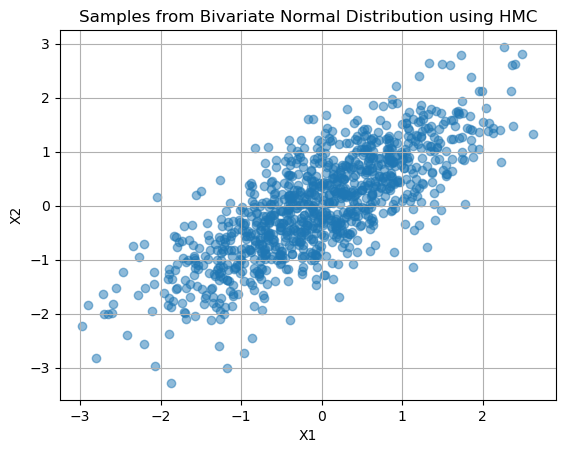

In [3]:
import matplotlib.pyplot as plt

# Plotting the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Samples from Bivariate Normal Distribution using HMC")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

#### Example 2: circular density 

Suppose we want to sample from
\begin{align*}
\pi(\theta) \propto\exp \left(-20\left(\|\theta\|_2-10\right)^2\right)
\end{align*}

Because of the squared term $\left(\|\theta\|_2-10\right)^2$, the density has the radial symmetry and the concentric rings of high density around the points where the Euclidean norm is approximately 10. The factor of -20 in front of the squared term indicates that the density decays rapidly as $\theta$ moves away from the points where $\|\theta\|_2$ equals 10. This means the density has a sharp peak at this radius and falls off quickly outside this region, i.e., like suppoted on a circle.

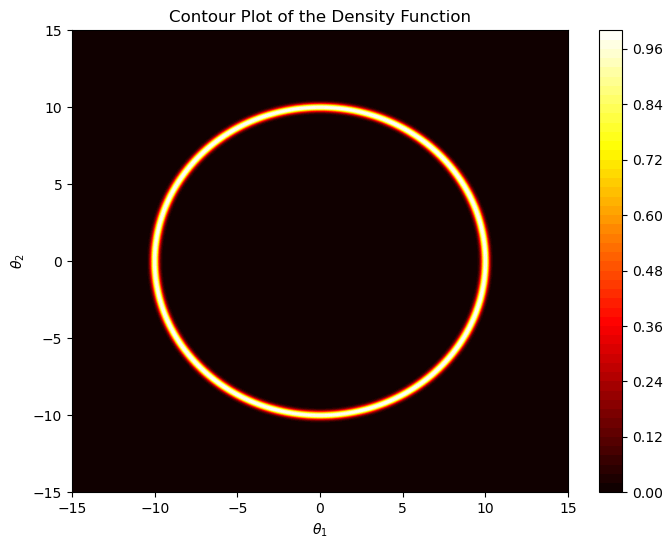

In [4]:
# Define the density function
def target(theta):
    return np.exp(-20 * (np.linalg.norm(theta) - 10)**2)

# Create a grid for the contour plot
x_vals = np.linspace(-15, 15, 400)
y_vals = np.linspace(-15, 15, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

# Compute the density values
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = target(np.array([X[i, j], Y[i, j]]))

# Generate the contour plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.colorbar()
plt.title("Contour Plot of the Density Function")
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")
plt.show()

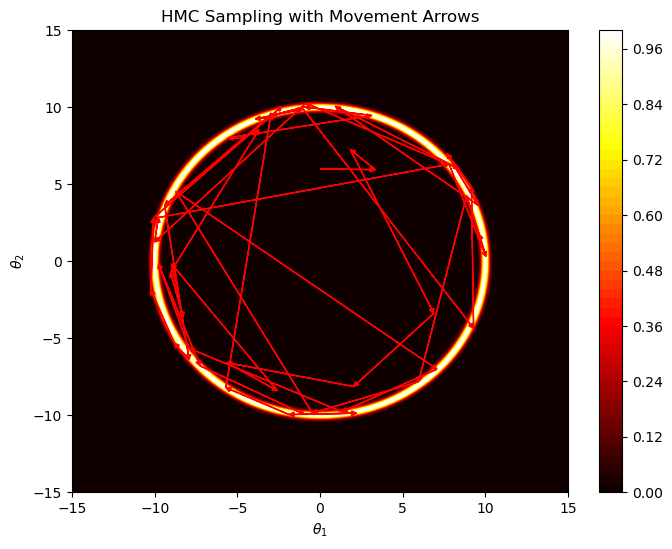

In [5]:
np.random.seed(2023) 

def target(theta):
    """ Target density function. """
    return np.exp(-20 * (np.linalg.norm(theta) - 10)**2)

def U(q):
    """ Potential energy function, which is the negative log of the target density. """
    return -np.log(target(q))

def grad_U(q):
    """ Gradient of the potential energy function. """
    norm_q = np.linalg.norm(q)
    if norm_q == 0:
        return np.zeros_like(q)
    return 40 * (norm_q - 10) * q / norm_q

# HMC parameters
epsilon = 0.2
L = 50
iterations = 50

# Initial position
current_q = np.array([0.0, 6.0])

# Sampling using HMC
samples = []
samples.append(current_q.copy())
acceptance_count = 0

for _ in range(iterations):
    new_q, accepted = HMC(U, grad_U, epsilon, L, current_q)
    current_q = new_q  # Update current_q with the new position
    samples.append(current_q.copy())  # Append new position
    acceptance_count += accepted

# Convert samples list to a numpy array
samples = np.array(samples)

# Create the contour plot of the target density function
x_vals = np.linspace(-15, 15, 400)
y_vals = np.linspace(-15, 15, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = target(np.array([X[i, j], Y[i, j]]))

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.colorbar()

# Plot the movement of points with arrows
for i in range(1, len(samples)):
    dx = samples[i][0] - samples[i-1][0]
    dy = samples[i][1] - samples[i-1][1]
    plt.arrow(samples[i-1][0], samples[i-1][1], dx, dy, 
              head_width=0.3, head_length=0.3, fc='red', ec='red', length_includes_head=True)

plt.title("HMC Sampling with Movement Arrows")
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")
plt.show()
